## Измерить сечение

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os.path
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylib.style as pys
import pylib.preprocess as preprocess
import pylib.fit as pyfit

%matplotlib inline
plt.rcParams['figure.dpi'] = 120

In [3]:
SEASON = 17
N_MC = 20000

In [4]:
exp_tree = uproot.open(f'../trees/{SEASON}/exp.root')['t']
mc_tree = uproot.open(f'../trees/{SEASON}/mc.root')['t']
df_exp = preprocess.read_tree(exp_tree, mc=False)
df_mc = preprocess.read_tree(mc_tree, mc=True)

assert np.any( df_exp.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 ) #check energies in df
assert np.any( df_mc.groupby('ebeam').agg(emean = ('emeas', 'mean'), uniqs = ('emeas', 'nunique')).uniqs==1 )

In [114]:
# df_exp.ksalign.hist(bins=100);

____
## Fit part

In [8]:
energies_list = df_exp.index.unique() & df_mc.index.unique()
for i in sorted(energies_list):
    print(i, end=' ')
it = iter(energies_list)

641.0 650.0 675.0 700.0 725.0 750.0 775.0 800.0 825.0 840.0 850.0 860.0 870.0 880.0 890.0 900.0 910.0 920.0 930.0 936.0 937.5 938.3 938.9 939.6 940.2 940.8 942.0 950.0 960.0 971.0 981.0 990.0 

[$\chi^2$-calculator](https://www.di-mgt.com.au/chisquare-calculator.html)

In [9]:
fit_range = (-40, 20)
hist_range = (-40, 40)
width = fit_range[1] - fit_range[0]

params = {
    'n_sig': (1000, (0, None)),    
    'n_bkg': (  10, (0, None)),    
    'm'    : (   0, (-5, 5)),
    'sL'   : (   2, (1, 10)),
    'sR'   : (   5, (1, 10)),
    'aL'   : (   0, (0, 10)),
    'aR'   : (   0, (0, 10)),
    'k'    : ( 0.1, (0, 20)),
}

In [10]:
def get_x1(df_exp, df_mc, e0):
    dfE = df_exp.loc[e0].copy()
    dfM =  df_mc.loc[e0].copy()
    assert dfM.runnum.nunique()==1
    return dfE, dfM
    
def get_params_exp(params, m_mc, non_limited=['n_sig', 'n_bkg', 'k']):
    params_exp = params.copy()
    for k in m_mc.parameters:
        params_exp[k] = ( m_mc.values[k], params_exp[k][1] )
        if k not in non_limited:
            mean, std = m_mc.values[k], 3*m_mc.errors[k]
            params_exp[k] = ( m_mc.values[k],(mean-std, mean+std) )
    return params_exp

In [160]:
e0 = next(it)
print(f'Energy {e0} MeV')

StopIteration: 

In [157]:
dfE, dfM = get_x1(df_exp, df_mc, e0)
dataE, dataM = dfE.x1.values, dfM.x1.values

m_mc = pyfit.fitter(dataM, fit_range, params.copy(), mc=True)
m_mc.simplex().migrad(iterate=20)
assert m_mc.valid

params_exp = get_params_exp(params, m_mc, ['n_sig', 'n_bkg', 'k'])
m_exp = pyfit.fitter(dataE, fit_range, params_exp, mc=False)
m_exp.simplex().migrad(iterate=20).migrad().migrad()
assert m_exp.valid

In [158]:
m_exp.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 90.92                      │             Nfcn = 1887              │
│ EDM = 5.35e-09 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_sig │    28     │     6     │     -6     │     6      │    0    │         │       │
│ 1 │ n_bkg │    58     │     7     │     -7     │     7      │    0    │         │       │
│ 2 │ m     │1.18302612252│1.00107078764│-0.50534609277│0.00000000022│-0.272002│ 1.18303 │       │
│ 3 │ sL    │2.7298244013│0.8908168055│-0.0000000012│0.7361717962│ 2.72982 │ 3.78713 │       │
│ 4 │ sR    │    3.1    │    0.9    │    -0.6    │    0.7     │ 2.53397 │ 3.86188 │       │
│ 5 │ aL    │113.70482958e-3│21.39166222e-3│-22.10275295e-3│0.00000034e-3│0.0916021│0.113705 │       │
│ 6 │ aR    │95.5994660945e-3│35.5336055040e-3│-0.0000000015e-3│24.1623447278e-3│0.0955995│0.144506 │       │
│ 7 │ k     │ 0.12e-12  │1125416167.36e-12│ -0.12e-12  │1126900362.94e-12│    0    │   20    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │         n_sig         │         n_bkg         │           m           │          sL           │          sR           │          aL           │          aR           │           k           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -6     │     6     │    -7     │     7     │-505346092.77e-9│  0.22e-9  │  -1.2e-9  │736171796.2e-9│   -0.6    │    0.7    │-22102752.95e-9│  0.34e-9  │ -1.5e-12  │24162344727.8e-12│ -0.12e-12 │1126900362.94e-12│
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   True    │   True    │   False   │   True    │   True    │   True    │   True    │   True    │   False   │   True    │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬─────────────────────────────────────────────────────────────────────────────────┐
│       │     n_sig     n_bkg         m        sL        sR        aL        aR         k │
├───────┼────────────────────────

,n_sig_exp,n_bkg_exp,n_sig_mc
950.0,11.248341,39.751663,603.058556
960.0,22.206669,54.793322,690.986506
971.0,16.991193,51.008832,860.932432
981.0,16.611041,51.389693,976.981542
990.0,27.665070,58.334950,1201.917644


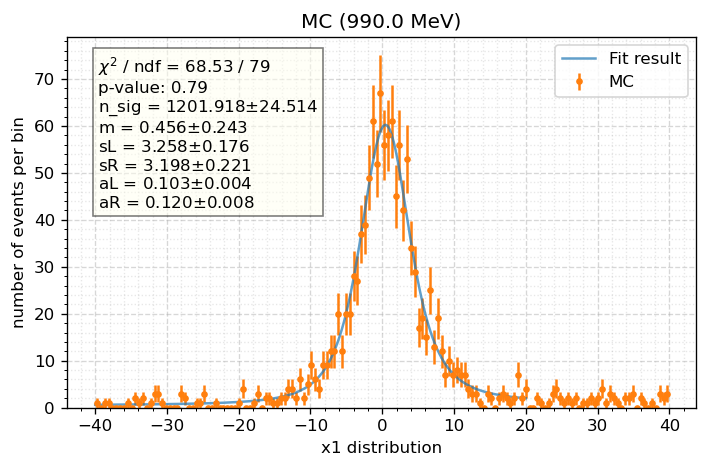

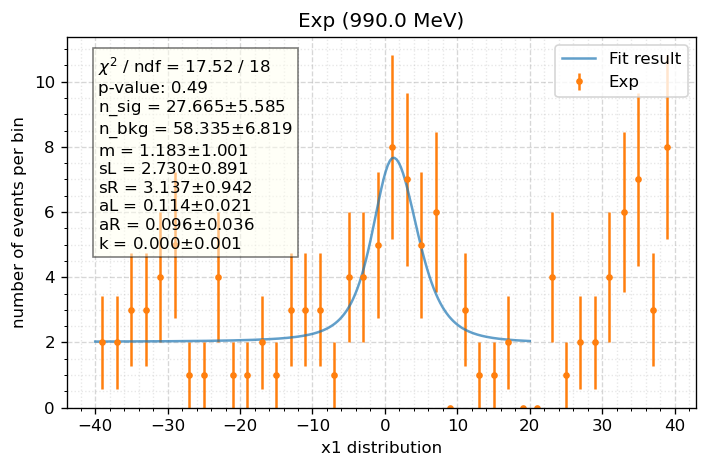

In [159]:
#Plot and save data

def plot_fit_data(save=True):
    pys.plot_fit(dataM, pyfit.sig_pdf, m_mc, 150, hist_range, fit_range, errors=True, label='MC', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'MC ({e0} MeV)', description=True)
    if save:
        if not(os.path.isdir(f'images/fit{SEASON}')):
            os.mkdir(f'images/fit{SEASON}')
        plt.savefig(f'images/fit{SEASON}/mc_{e0}.png', dpi=120)

    pys.plot_fit(dataE, pyfit.pdf, m_exp, 40, hist_range, fit_range, errors=True, label='Exp', xtitle='x1 distribution',
               ytitle='number of events per bin', title=f'Exp ({e0} MeV)', description=True)
    if save:
        plt.savefig(f'images/fit{SEASON}/exp_{e0}.png', dpi=120)

plot_fit_data(save=True)
    
if 'res_df' not in locals():
    def add_postfix(arr, post):
        return [f'{_}_{post}' for _ in arr]
    cols = add_postfix(m_exp.parameters, 'exp') + add_postfix(m_exp.parameters, 'exp_err') + \
        add_postfix(m_mc.parameters, 'mc') + add_postfix(m_mc.parameters, 'mc_err') + ['emeas']
    res_df = pd.DataFrame(columns=cols)
    del cols
temp_ser = pd.Series(list(m_exp.values) + list(m_exp.errors) + 
                     list(m_mc.values) + list(m_mc.errors) + [dfE.emeas.mean()], index=res_df.columns, name=e0)
if temp_ser.name in res_df.index:
    res_df.drop(temp_ser.name, axis=0, inplace=True)
res_df = res_df.append(temp_ser)
del temp_ser

res_df[['n_sig_exp', 'n_bkg_exp', 'n_sig_mc']].tail()

Распределения

In [162]:
# res_df.to_csv(f'../data/{SEASON}/results/signal.csv')

In [161]:
res_df[['n_sig_exp', 'n_sig_exp_err']]

,n_sig_exp,n_sig_exp_err
641.0,352.328084,17.468406
650.0,106.733137,12.441450
675.0,92.109045,12.046118
700.0,54.870984,9.700130
725.0,83.944604,11.899339
750.0,117.429777,10.942273
775.0,143.334079,9.629576
800.0,280.846588,14.340400
825.0,291.060724,16.054307
840.0,83.121625,7.132346


Triggers

In [163]:
df_exp

,runnum,emeas,trigbits,tth[0],tth[1],tz[0],tz[1],tptot[0],tptot[1],trho[0],...,ksminv,ksptot,ksalign,kslen,ksdpsi,kspipt[0],kspipt[1],x1,x2,ksangle
ebeam,,,,,,,,,,,,,,,,,,,,,
641.0,46812,641.018494,3,0.895795,2.244962,-1.198752,0.000516,277.124603,279.089447,-0.491146,...,491.126068,385.454224,0.999579,0.986818,1.618001,277.960052,280.483459,3.506160,-19.426342,0.029018
641.0,46812,641.018494,3,1.758388,2.508982,-5.216975,-2.264647,214.774307,295.423218,0.169626,...,492.080200,207.598526,0.984980,0.915306,2.200497,214.778763,240.349472,91.581843,-173.945705,0.173537
641.0,46813,641.018494,1,1.691996,0.643109,1.606246,0.244816,250.719955,234.579086,0.774311,...,499.891968,169.012161,0.998680,2.741790,2.404552,251.034134,195.816055,117.317106,-203.738783,0.051396
641.0,46813,641.018494,3,1.705701,2.161999,-2.368094,-2.132150,98.920624,446.422821,-0.574948,...,502.166382,401.185364,0.999804,1.019325,2.192727,98.796379,450.626740,5.410278,-0.302231,0.019792
641.0,46813,641.018494,3,1.308617,1.613101,3.886285,3.989652,185.139740,304.757538,0.372143,...,496.785065,273.288025,0.992166,0.387954,2.054172,185.114105,304.716309,63.458847,-114.394525,0.125251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003.5,43642,1003.312012,1,1.800264,1.455261,-11.699976,-12.916196,225.315872,152.189484,-2.331621,...,466.139526,69.468590,0.998727,8.083248,2.982980,220.373993,157.488617,207.523972,-775.069960,0.050471
1003.5,43642,1003.312012,3,1.085202,2.431300,3.698641,6.023173,308.684357,372.747070,0.101917,...,508.732574,532.036987,0.999145,1.120649,1.354665,307.194183,373.478943,111.138368,-320.654395,0.041363
1003.5,43642,1003.312012,3,1.957868,1.236746,1.145160,0.210003,265.862396,107.915260,0.546389,...,438.425964,183.587936,0.991770,1.269511,2.575486,264.811066,107.173996,147.239777,-674.287608,0.128386


In [165]:
trig_df = pd.DataFrame()
for ee in energies_list:
    dfE = df_exp.loc[ee].copy()
    dfM = df_mc.loc[ee].copy()
#     print(ee)
    assert dfM.runnum.nunique()==1
    xmin, xmax = fit_range
    dfE = dfE.query('x1<@xmax&x1>@xmin')[['trigbits']]
    dfE[ee] = 1
    trig_df = trig_df.append(pd.pivot_table(dfE, values=ee, columns='trigbits', aggfunc='sum'))
trig_df = trig_df.fillna(0).drop(0, axis=1).rename({1: 'TF', 2: 'CF', 3:'TC'}, axis=1)

In [166]:
t, c, tc = trig_df['TF'] + trig_df['TC'], trig_df['CF'] + trig_df['TC'], trig_df['TC']

trig_df['effT'] = (tc + 1)/(c + 2)
trig_df['effC'] = (tc + 1)/(t + 2)

trig_df['effT_err'] = np.sqrt( (tc+1)*(tc+2)/(c+2)/(c+3) - ((tc+1)/(c+2))**2 )
trig_df['effC_err'] = np.sqrt( (tc+1)*(tc+2)/(t+2)/(t+3) - ((tc+1)/(t+2))**2 )

trig_df['eff_trig']  = 1 - (1-trig_df.effT)*(1-trig_df.effC)
trig_df['eff_trig_err']  = np.sqrt( (trig_df.effT_err*(1-trig_df.effC))**2 
                             + (trig_df.effC_err*(1-trig_df.effT))**2 )

In [167]:
# trig_df.to_csv(f'../data/{SEASON}/results/triggers.csv')

Если не фиксировать параметры в экспериментальном распределении, то провожу статистический тест.

Гипотеза $H_0$ - параметры распределений в эксперименте и моделировании одинаковы

Проверяем гипотезу на уровне значимости 5% = $2 \cdot \sigma$

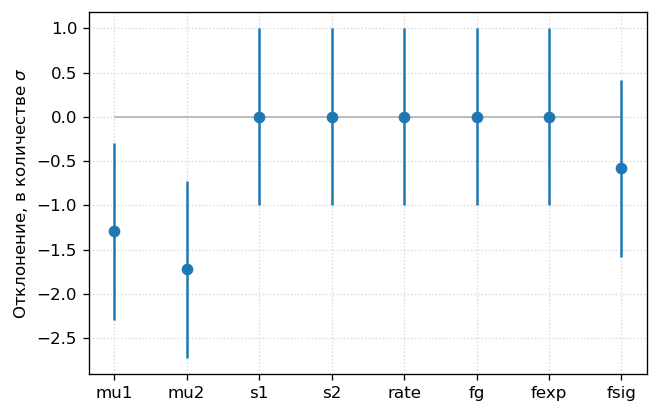

In [639]:
valsE, errsE = m_exp.values, m_exp.errors
valsM, errsM = m_mc.values, m_mc.errors
x0, ex = [], []
var =  ['mu1', 'mu2', 's1', 's2', 'rate', 'fg', 'fexp', 'fsig']
for k in var:
    error = (np.sqrt(errsE[k]**2 + errsM[k]**2))
    x0.append((valsE[k] - valsM[k])/error)
    
plt.hlines(y=0, xmin=0, xmax=len(x0)-1, zorder=-1, color='k', lw=1, alpha=0.3)
plt.errorbar(range(len(x0)), x0, yerr=1, fmt='o')
plt.grid(ls=':', alpha=0.5)
plt.ylabel('Отклонение, в количестве $\\sigma$')
plt.xticks(range(len(x0)), var);
# del valsE, valsM, errsE, errsM